In [1]:
import numpy as np
import pandas as pd
# import geopandas as gpd
import matplotlib.pyplot as plt 
import json
%pylab inline 
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
!ls ../share/data/processed/

brand_info_food.csv	       poi_weekly_20211029.csv
cbg_attr_and_cluster_1009.csv  social_distancing_nyc.csv
cbg_attr_and_cluster_1021.csv  weekly_and_core.csv
cbg_distance_matrix.csv        weekly_and_core_with_area.csv
files			       weekly_brand_info.csv
home_weekly_20211029.csv       weekly_patterns_with_general_info.csv
placekey_and_area.csv	       weekly_trips_20211017.csv
poi_info.csv		       weekly_trips_by_cbg.csv


In [102]:
# First week of 2019.
DATE_START = pd.to_datetime('2018-12-31 00:00:00-05:00')
# Last week of 2020.
DATE_END = pd.to_datetime('2020-01-25 00:00:00-05:00')

# First week of 2020.
DATE_START_PLOT = pd.to_datetime('2019-12-30 00:00:00-05:00')
# CUTOFF BEFORE DATA GAP
DATE_END_PLOT = pd.to_datetime('2020-11-23 00:00:00-05:00')

# Start of COVID-19 Pre-Pandemic Period
DATE_START_PRE_COVID = pd.to_datetime('2019-03-18 00:00:00-05:00')
DATE_END_PRE_COVID = pd.to_datetime('2019-11-25 00:00:00-05:00')

# Start of COVID-19 Pre-Pandemic Period -/+ 1 week
DATE_START_PRE_COVID_ROLLING = pd.to_datetime('2019-03-11 00:00:00-05:00')
DATE_END_PRE_COVID_ROLLING = pd.to_datetime('2019-12-02 00:00:00-05:00')

# Start of COVID-19 Pandemic Period
DATE_START_COVID_ROLLING = pd.to_datetime('2020-03-16 00:00:00-05:00')
DATE_END_COVID_ROLLING = pd.to_datetime('2020-11-23 00:00:00-05:00')

# Start of COVID-19 Pandemic Period -/+ 1 week
DATE_START_COVID_ROLLING = pd.to_datetime('2020-03-09 00:00:00-05:00')
DATE_END_COVID_ROLLING = pd.to_datetime('2020-11-30 00:00:00-05:00')

# First week of 2019 - 1 week.
DATE_START_ROLLING = pd.to_datetime('2018-12-24 00:00:00-05:00')
# Last week of 2020 + 1 week.
DATE_END_ROLLING = pd.to_datetime('2021-02-01 00:00:00-05:00')

In [78]:
# https://cran.r-project.org/web/packages/khroma/vignettes/tol.html + NYU
COLORS = [
    '#57068c', '#e0b6fc', '#825', '#173', '#dc7', '#4a9', '#c67', '#993', '#a49']
LINE_STYLES = [
    'solid',
    'dashed',
    (0, (1, 1)),
    'dashdot',
    'solid',
    (0, (5, 1)),
    (0, (3, 1, 1, 1, 1, 1)),
    'dashed',
    'dashdot',
]

In [150]:
FONT_SIZE_TICKS=13
FONT_SIZE_AXIS=14
FONT_SIZE_TITLE=16
FONT_SIZE_LEGEND=14

In [79]:
def peek(df):
    display(df.iloc[0:3, :])
    print(len(df))

In [88]:
def repair_dates(df):
    df['date_range_start'] = pd.to_datetime(df['date_range_start'], utc=True)
    df['date_range_start'] = df['date_range_start'].dt.tz_convert('US/Eastern')

In [80]:
cluster_attr = pd.read_csv('./data/cbg_attr_and_cluster_1021.csv')
clusters = cluster_attr[['census_block_group', 'Cluster']].set_index('census_block_group')
clusters.head()

,Cluster
census_block_group,
360050001001,2
360050002001,2
360050002002,2
360050002003,3
360050004001,3


In [81]:
poi = pd.read_csv('./exports/poi_health_recategorized.csv')

In [82]:
#poiHealth.category.unique()

In [83]:
other_retail = [
    'Beer, Wine, and Liquor Stores',
    'Big Box Grocers',
    #'Delis and Convenience Stores',
    'Food Services',
    'General Merchandise Stores',
    'Specialty Food Stores',
    'Tobacco Stores',
]

other_service = [
    'Drinking Places',
    'Snacks and Bakeries',
]

In [84]:
poi['combined_category'] = poi['category']
poi.loc[poi['category'].isin(other_retail), 'combined_category'] = 'Other Food Retail'
poi.loc[poi['category'].isin(other_service), 'combined_category'] = 'Other Food Service'

In [85]:
poi.columns

Index(['placekey', 'cbg', 'naics_code', 'category', 'sub_category',
       'location_name', 'area_square_feet', 'latitude', 'longitude',
       'combined_category'],
      dtype='object')

In [86]:
categories = poi[['placekey', 'category', 'combined_category', 'cbg']]
categories.head()

,placekey,category,combined_category,cbg
0,222-222@627-s94-nwk,Specialty Food Stores,Other Food Retail,360470395002
1,223-222@627-rw6-zfz,Supermarkets and Grocery Stores,Supermarkets and Grocery Stores,360050386008
2,223-222@627-rwq-vcq,Supermarkets and Grocery Stores,Supermarkets and Grocery Stores,360050117001
3,223-222@627-sb5-8jv,Supermarkets and Grocery Stores,Supermarkets and Grocery Stores,360810107011
4,223-222@627-tkd-fvf,Supermarkets and Grocery Stores,Supermarkets and Grocery Stores,360811032021


In [87]:
trips = pd.read_csv('./exports/home_weekly.csv')
trips = trips.merge(categories, on='placekey')
trips = trips.merge(clusters, left_on='home_cbg', right_on='census_block_group')
trips.head(3)

,placekey,date_range_start,home_cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi,category,combined_category,cbg,Cluster
0,236-222@627-s7z-b6k,2018-12-31 00:00:00-05:00,360050001001,4,264.0,0.25,0.25,20.076046,Full-Service Restaurants,Full-Service Restaurants,360471194001,2
1,223-222@627-wg7-7h5,2018-12-31 00:00:00-05:00,360050001001,4,264.0,0.25,0.25,25.872502,Fast Food Restaurants,Fast Food Restaurants,360470930002,2
2,22v-222@627-wg4-t5f,2018-12-31 00:00:00-05:00,360050001001,4,264.0,0.25,0.25,22.579698,Full-Service Restaurants,Full-Service Restaurants,360470828002,2


In [89]:
repair_dates(trips)
trips['date'] = trips.date_range_start.dt.date
trips['year'] = trips.date_range_start.dt.year
trips['month'] = trips.date_range_start.dt.month

In [90]:
max(trips.date_range_start)

Timestamp('2021-02-15 00:00:00-0500', tz='US/Eastern')

In [91]:
# set the figure and font size
#import seaborn as sns 
import matplotlib.ticker as mtick
#sns.set(rc={"font.size":18, "axes.titlesize":18, "axes.labelsize":16}) # 'figure.figsize':(20, 8), 
#sns.reset_orig()

### POI Count per Capita by category

In [92]:
# home POI Count

In [93]:
def get_count_and_pct_df(df, pop, column_label):
    
    Count = df[['placekey', column_label, 'Cluster']].groupby(['Cluster', column_label]).count()
    Count = pd.pivot_table(Count, values='placekey', index=['Cluster'], columns=[column_label])
    for i in Count.columns:
        Count[i] = Count[i] / pop['Total Population'] * 1000 # per 1000 capita
    
    Pct = Count.copy()
    for i in Pct.columns:
        Pct[i] = Pct[i]/Count.sum(axis=1)
    
    return Count, Pct

In [94]:
#homepoi = categories.merge(clusters, left_on='cbg', right_on='census_block_group')
#clPop = cluster_attr[['Cluster', 'Total Population']].groupby('Cluster').sum()
#poiCount, poiPct = get_count_and_pct_df(homepoi, clPop, 'combined_category')

In [95]:
def poi_plots(count_df, pct_df, which_type):
    
    fig, ax = plt.subplots(1,2,figsize=(18,5))

    cmap = plt.cm.get_cmap('tab20')
    colors = [cmap(i / 20) for i in range(0, 20)]

    count_df.plot.bar(color=colors, ax=ax[0])
    ax[0].set(xlabel='Clusters', ylabel='Number per 1000 Capita', title='%s POI Count per 1000 Capita' % which_type, xticks=count_df.index)
    ax[0].tick_params(axis='x', rotation=0, size=18)
    ax[0].get_legend().remove()

    for i in range(pct_df.shape[1]):
        if i == 0:
            ax[1].bar(pct_df.index, pct_df.iloc[:, i], width=0.75, color=colors[i], label=pct_df.columns[i], alpha=0.8)
        else:
            ax[1].bar(pct_df.index, pct_df.iloc[:, i], bottom=np.sum(pct_df.iloc[:, :i], axis=1), 
                      width=0.75, color=colors[i], label=pct_df.columns[i], alpha=0.8)
    ax[1].set(xlabel='Clusters', ylabel='Percentage', title='%s POI Category Composition' % which_type, xticks=pct_df.index)
    ax[1].legend(bbox_to_anchor=(0.45, -0.25, 0.1, 0.1), ncol=4, loc='lower center', 
                  bbox_transform=fig.transFigure, fontsize=15)
    ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

In [96]:
#poi_plots(poiCount, poiPct, 'Home')

In [97]:
#poiCount.sum(axis=1)

In [98]:
#plt.figure(figsize=(8, 4))
#sns.boxplot(data=poiCount)
#plt.xticks(fontsize=12, rotation=90)
#plt.title('Home POI Count')
## plt.ylabel()
#plt.xlabel(None)

In [22]:
# Visited POI count by category

In [99]:
#vstCount, vstPct = get_count_and_pct_df(trips, 'combined_category')

In [100]:
#poi_plots(vstCount, vstPct, 'Visited')

In [101]:
# 2019 V.S. 2020 Visited (Mar - Nov) -- number decreased

In [103]:
trip2019 = trips[(trips['date_range_start'] >= DATE_START_PRE_COVID_ROLLING) & (trips['date_range_start'] <= DATE_END_PRE_COVID_ROLLING)]
trip2020 = trips[(trips['date_range_start'] >= DATE_START_COVID_ROLLING) & (trips['date_range_start'] <= DATE_END_COVID_ROLLING)]

In [25]:
#vstCount19, vstPct19 = get_count_and_pct_df(trip2019, 'combined_category')
#vstCount20, vstPct20 = get_count_and_pct_df(trip2020, 'combined_category')

TypeError: get_count_and_pct_df() missing 1 required positional argument: 'column_label'

In [ ]:
#changeCount = vstCount20-vstCount19
#changePct = (vstCount20-vstCount19)/vstCount19

In [ ]:
#fig, ax = plt.subplots(1,2,figsize=(20,5))
#
#changeCount.T.plot.bar(cmap='tab20c', ax=ax[0])
#ax[0].set(xlabel=None, ylabel='Number', title='Changes of Visited POI Count')
#ax[0].tick_params(axis='x', labelsize=15)
#
#sns.boxplot(data=changePct, ax=ax[1])
#ax[1].set(xlabel=None, ylabel='Percentage', title='Percent Changes of Visited POI Count')
#ax[1].tick_params(axis='x', labelsize=15, rotation=90)

### Estimated visitor count by category

In [104]:
def get_evc_pct_pivot_table(df, value_name, column_label):

    evc = df[['Cluster', column_label, value_name]].groupby(['Cluster', column_label], as_index=False).median()
    evc = pd.pivot_table(evc, values=value_name, index=['Cluster'], columns=[column_label])
    
    evcPct = evc.copy()
    for i in evcPct.columns:
        evcPct[i] = evcPct[i]/evc.sum(axis=1)

    return evc, evcPct

In [105]:
#evc19, evcPct19 = get_evc_pct_pivot_table(trip2019, 'estimated_visitor_count', 'combined_category')
#evc20, evcPct20 = get_evc_pct_pivot_table(trip2020, 'estimated_visitor_count', 'combined_category')

In [106]:
#evcChg = evcPct20 - evcPct19
#evcChg.plot.bar(figsize=(10,5), width=0.7)
#plt.title('% Changes of Visitation from Home')
#plt.ylabel('Percentage')
#plt.xticks(rotation=0)
#plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

In [107]:
# the detailed categories
#_, evcPct19_ = get_evc_pct_pivot_table(trip2019, 'estimated_visitor_count', 'category')
#_, evcPct20_ = get_evc_pct_pivot_table(trip2020, 'estimated_visitor_count', 'category')
#evcChg_ = evcPct20_ - evcPct19_
#evcChg_.plot.bar()

### Time-series /Cluster /Category

In [132]:
tp19 = trip2019[['date_range_start', 'estimated_visitor_count', 'combined_category', 'Cluster']]

tp19 = tp19.groupby(['combined_category', 'Cluster', 'date_range_start'], as_index=False).agg({'estimated_visitor_count': 'sum'})
tp19_total = tp19.groupby(['Cluster', 'date_range_start'], as_index=False).agg({'estimated_visitor_count': 'sum'})
tp19_total = tp19_total.rename(columns={'estimated_visitor_count': 'estimated_visitor_total'})
tp19 = tp19.merge(tp19_total, on=['Cluster', 'date_range_start'], how='inner')
tp19['proportion'] = tp19['estimated_visitor_count'] / tp19['estimated_visitor_total']
tp19 = pd.pivot_table(tp19, values='proportion', index=['date_range_start'], columns=['combined_category', 'Cluster'])
tp19 = tp19.sort_values(by=['date_range_start'])
tp19[tp19.columns] = tp19[tp19.columns].rolling(3, center=True).mean()
tp19 = tp19[(tp19.index >= DATE_START_PRE_COVID) & (tp19.index <= DATE_END_PRE_COVID)]
tp19 = tp19.reset_index(drop=True)
peek(tp19)

combined_category Delis and Convenience Stores                                \
Cluster                                      0         1         2         3   
0                                     0.042307  0.029221  0.047820  0.035778   
1                                     0.041797  0.029155  0.048347  0.035909   
2                                     0.041623  0.029593  0.048713  0.036090   

combined_category Fast Food Restaurants                                \
Cluster                               0         1         2         3   
0                              0.148557  0.106472  0.130044  0.118265   
1                              0.148583  0.107119  0.128919  0.118371   
2                              0.148210  0.107656  0.129287  0.117726   

combined_category Full-Service Restaurants            ... Other Food Service  \
Cluster                                  0         1  ...                  2   
0                                 0.353329  0.366027  ...           0.137359   
1                                 0.352609  0.365799  ...           0.137269   
2                                 0.352511  0.366345  ...           0.136564   

combined_category           Pharmacies and Drug Stores                      \
Cluster                   3                          0         1         2   
0                  0.157013                   0.064123  0.038822  0.070107   
1                  0.156868                   0.064668  0.038125  0.071377   
2                  0.155158                   0.065301  0.038616  0.070920   

combined_category           Supermarkets and Grocery Stores            \
Cluster                   3                               0         1   
0                  0.058171                        0.066658  0.038063   
1                  0.058018                        0.066353  0.038366   
2                  0.057792                        0.067243  0.039177   

combined_category                      
Cluster                   2         3  
0                  0.067920  0.059372  
1                  0.068213  0.059724  
2                  0.069390  0.060078  

[3 rows x 32 columns]

36


In [133]:
tp20 = trip2020[['date_range_start', 'estimated_visitor_count', 'combined_category', 'Cluster']]

tp20 = tp20.groupby(['combined_category', 'Cluster', 'date_range_start'], as_index=False).agg({'estimated_visitor_count': 'sum'})
tp20_total = tp20.groupby(['Cluster', 'date_range_start'], as_index=False).agg({'estimated_visitor_count': 'sum'})
tp20_total = tp20_total.rename(columns={'estimated_visitor_count': 'estimated_visitor_total'})
tp20 = tp20.merge(tp20_total, on=['Cluster', 'date_range_start'], how='inner')
tp20['proportion'] = tp20['estimated_visitor_count'] / tp20['estimated_visitor_total']
tp20 = pd.pivot_table(tp20, values='proportion', index=['date_range_start'], columns=['combined_category', 'Cluster'])
tp20 = tp20.sort_values(by=['date_range_start'])
tp20[tp20.columns] = tp20[tp20.columns].rolling(3, center=True).mean()
tp20 = tp20[(tp20.index >= DATE_START_COVID) & (tp20.index <= DATE_END_COVID)]
tp20 = tp20.reset_index(drop=True)
peek(tp20)

combined_category Delis and Convenience Stores                                \
Cluster                                      0         1         2         3   
0                                     0.043351  0.036130  0.050264  0.041960   
1                                     0.043689  0.036182  0.050643  0.042753   
2                                     0.044248  0.035952  0.049239  0.042771   

combined_category Fast Food Restaurants                                \
Cluster                               0         1         2         3   
0                              0.147515  0.105739  0.125478  0.114001   
1                              0.154357  0.107972  0.128031  0.119046   
2                              0.159502  0.110838  0.130467  0.123452   

combined_category Full-Service Restaurants            ... Other Food Service  \
Cluster                                  0         1  ...                  2   
0                                 0.314853  0.328390  ...           0.106178   
1                                 0.314331  0.327154  ...           0.100547   
2                                 0.311244  0.323356  ...           0.099096   

combined_category           Pharmacies and Drug Stores                      \
Cluster                   3                          0         1         2   
0                  0.119207                   0.085564  0.064737  0.085165   
1                  0.114731                   0.086458  0.064691  0.085438   
2                  0.110685                   0.086983  0.065620  0.086214   

combined_category           Supermarkets and Grocery Stores            \
Cluster                   3                               0         1   
0                  0.082725                        0.116150  0.100937   
1                  0.084880                        0.116551  0.104704   
2                  0.084629                        0.117529  0.107098   

combined_category                      
Cluster                   2         3  
0                  0.115658  0.118980  
1                  0.120170  0.124121  
2                  0.121349  0.124588  

[3 rows x 32 columns]

36


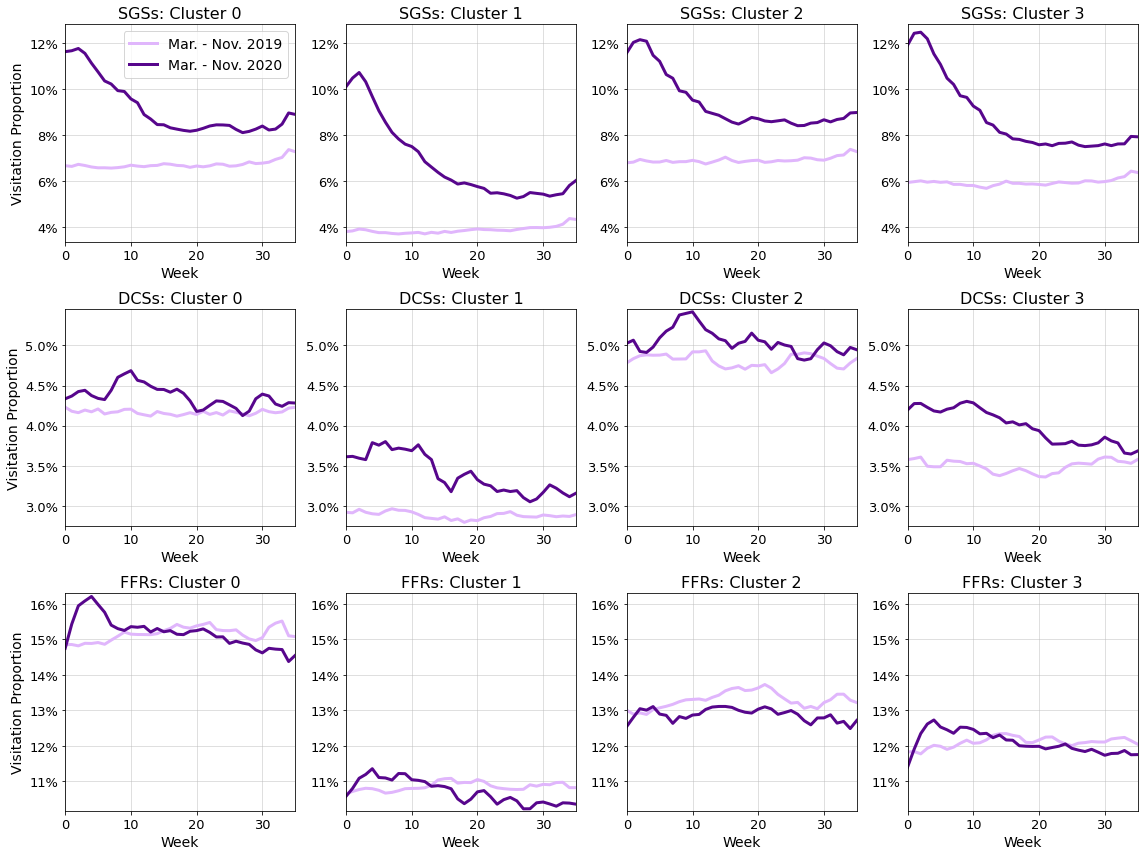

In [186]:
plot_categories = [
    tp20.columns.levels[0][7],
    tp20.columns.levels[0][0],
    tp20.columns.levels[0][1],
]

category_names = ['SGSs', 'DCSs', 'FFRs']

s = 4
fig, ax = plt.subplots(len(plot_categories), 4, figsize=(s * 4, s * len(plot_categories)))

    #fig.suptitle('Visitation for %s ' % category,
    #             fontsize=16,
    #             verticalalignment='top')
for i, category in enumerate(plot_categories):

    min_y = 1
    max_y = 0

    for cl in range(4):
        tp19[(category, cl)].plot(ax=ax[i, cl], label='Mar. - Nov. 2019', legend=(i==0 and cl==0), color=COLORS[1], linewidth=3)
        tp20[(category, cl)].plot(ax=ax[i, cl], label='Mar. - Nov. 2020', legend=(i==0 and cl==0), color=COLORS[0], linewidth=3)
        ax[i, cl].set_title(f'{category_names[i]}: Cluster {cl}', fontsize=FONT_SIZE_TITLE)
        min_y = min(min_y, ax[i, cl].get_ylim()[0])
        max_y = max(max_y, ax[i, cl].get_ylim()[1])

        ax[i, cl].grid(color='#bdbdbd', alpha=0.6, zorder=1)

    for cl in range(4):
        ax[i, cl].set_xlim([0, len(tp20) - 1])
        ax[i, cl].set_xlabel('Week', fontsize=FONT_SIZE_AXIS)
        ax[i, cl].set_ylim([min_y, max_y])
        ax[i, cl].tick_params(axis='x', labelsize=FONT_SIZE_TICKS)
        ax[i, cl].tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
        ax[i, cl].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=(1 if i == 1 else 0)))
        ax[i, 0].set_ylabel('Visitation Proportion', fontsize=FONT_SIZE_AXIS)
        
    if i == 0:
        ax[0, 0].legend(fontsize=FONT_SIZE_LEGEND)

plt.tight_layout()
plt.show()

In [29]:
# get category % of each cluser each day
tp20pct = tp20.copy()
for c in range(4):
    total_each_week = tp20pct[list(tp20pct.columns[c+4*i] for i in range(7))].sum(axis=1)
    for k in range(7):
        tp20pct[tp20pct.columns[c+4*k]] = tp20pct[tp20pct.columns[c+4*k]] / total_each_week
tp20pct.head()

combined_category Fast Food Restaurants                                \
Cluster                               0         1         2         3   
date                                                                    
03-02                          0.142167  0.138845  0.140694  0.142051   
03-09                          0.140837  0.137857  0.141208  0.141654   
03-16                          0.141640  0.137157  0.139188  0.140117   
03-23                          0.141496  0.132007  0.138097  0.139996   
03-30                          0.141314  0.133968  0.140722  0.141138   

combined_category Full-Service Restaurants                                \
Cluster                                  0         1         2         3   
date                                                                       
03-02                             0.142236  0.141050  0.143875  0.143256   
03-09                             0.140590  0.142762  0.143826  0.143465   
03-16                             0.140774  0.142835  0.143283  0.144431   
03-23                             0.143906  0.146080  0.144596  0.144199   
03-30                             0.142513  0.143313  0.144440  0.143765   

combined_category Limited-Service Restaurants            ...  \
Cluster                                     0         1  ...   
date                                                     ...   
03-02                                0.140142  0.146293  ...   
03-09                                0.141014  0.144763  ...   
03-16                                0.139856  0.143987  ...   
03-23                                0.141587  0.146906  ...   
03-30                                0.141070  0.147392  ...   

combined_category Other Food Service           Pharmacies and Drug Stores  \
Cluster                            2         3                          0   
date                                                                        
03-02                       0.144479  0.144191                   0.142385   
03-09                       0.143521  0.142090                   0.143013   
03-16                       0.143930  0.143026                   0.143425   
03-23                       0.144580  0.143518                   0.142246   
03-30                       0.142840  0.142740                   0.140624   

combined_category                                \
Cluster                   1         2         3   
date                                              
03-02              0.138692  0.142017  0.142119   
03-09              0.138111  0.141038  0.143862   
03-16              0.136865  0.142058  0.142139   
03-23              0.130090  0.141161  0.141563   
03-30              0.132770  0.140630  0.143419   

combined_category Supermarkets and Grocery Stores                      \
Cluster                                         0         1         2   
date                                                                    
03-02                                    0.145355  0.140917  0.144479   
03-09                                    0.146279  0.147920  0.146824   
03-16                                    0.146393  0.150627  0.147537   
03-23                                    0.143786  0.146791  0.144771   
03-30                                    0.144998  0.147345  0.145752   

combined_category            
Cluster                   3  
date                         
03-02              0.145843  
03-09              0.146446  
03-16              0.147649  
03-23              0.146324  
03-30              0.144995  

[5 rows x 28 columns]

In [187]:
# get category % of each cluser each day
tp19pct = tp19.copy()
for c in range(4):
    total_each_week = tp19pct[list(tp19pct.columns[c+4*i] for i in range(7))].sum(axis=1)
    for k in range(7):
        tp19pct[tp19pct.columns[c+4*k]] = tp19pct[tp19pct.columns[c+4*k]] / total_each_week
tp19pct.head()

combined_category Fast Food Restaurants                                \
Cluster                               0         1         2         3   
date                                                                    
03-04                          0.143130  0.140745  0.141217  0.140652   
03-11                          0.142643  0.139493  0.141712  0.140973   
03-18                          0.143647  0.139981  0.141705  0.140953   
03-25                          0.142950  0.139962  0.141076  0.140882   
04-01                          0.142873  0.139234  0.141915  0.141414   

combined_category Full-Service Restaurants                                \
Cluster                                  0         1         2         3   
date                                                                       
03-04                             0.142884  0.142337  0.143865  0.143268   
03-11                             0.142270  0.142034  0.144392  0.143126   
03-18                             0.142743  0.142594  0.143770  0.142653   
03-25                             0.142950  0.143556  0.144305  0.142116   
04-01                             0.143044  0.142506  0.144089  0.142755   

combined_category Limited-Service Restaurants            ...  \
Cluster                                     0         1  ...   
date                                                     ...   
03-04                                0.142612  0.142739  ...   
03-11                                0.143841  0.145915  ...   
03-18                                0.142860  0.143598  ...   
03-25                                0.142950  0.144892  ...   
04-01                                0.143060  0.144514  ...   

combined_category Other Food Service           Pharmacies and Drug Stores  \
Cluster                            2         3                          0   
date                                                                        
03-04                       0.145721  0.143853                   0.142459   
03-11                       0.144682  0.142509                   0.141356   
03-18                       0.143708  0.143507                   0.142093   
03-25                       0.145142  0.143437                   0.142957   
04-01                       0.144444  0.143202                   0.142283   

combined_category                                \
Cluster                   1         2         3   
date                                              
03-04              0.140326  0.140744  0.143527   
03-11              0.140932  0.141243  0.143678   
03-18              0.141216  0.141844  0.143830   
03-25              0.139275  0.141183  0.143367   
04-01              0.141876  0.142324  0.143829   

combined_category Supermarkets and Grocery Stores                      \
Cluster                                         0         1         2   
date                                                                    
03-04                                    0.143438  0.145006  0.143865   
03-11                                    0.143364  0.144639  0.144613   
03-18                                    0.143334  0.144055  0.144212   
03-25                                    0.142102  0.142645  0.142123   
04-01                                    0.143379  0.145144  0.143462   

combined_category            
Cluster                   3  
date                         
03-04              0.144555  
03-11              0.145261  
03-18              0.145142  
03-25              0.146334  
04-01              0.145749  

[5 rows x 28 columns]

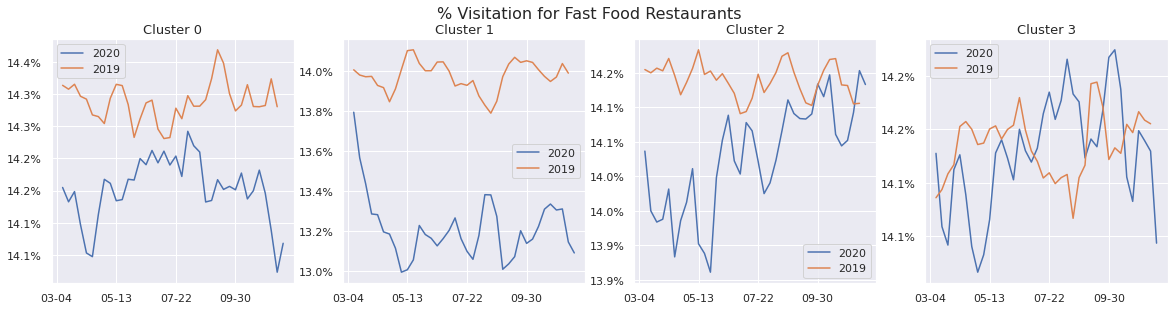

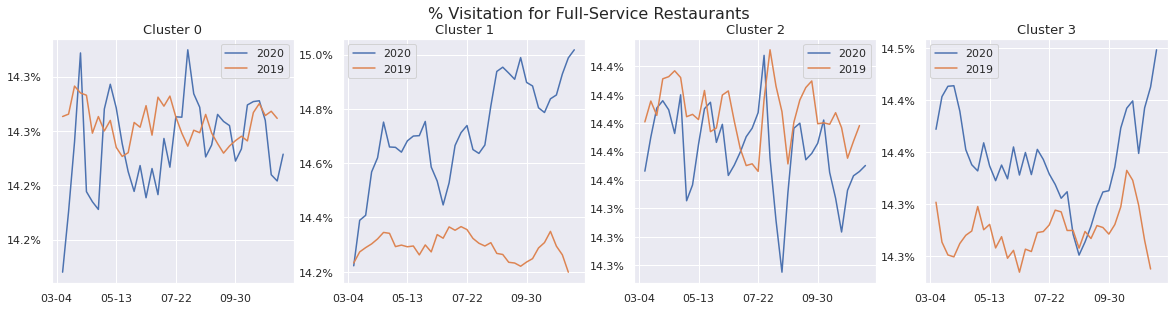

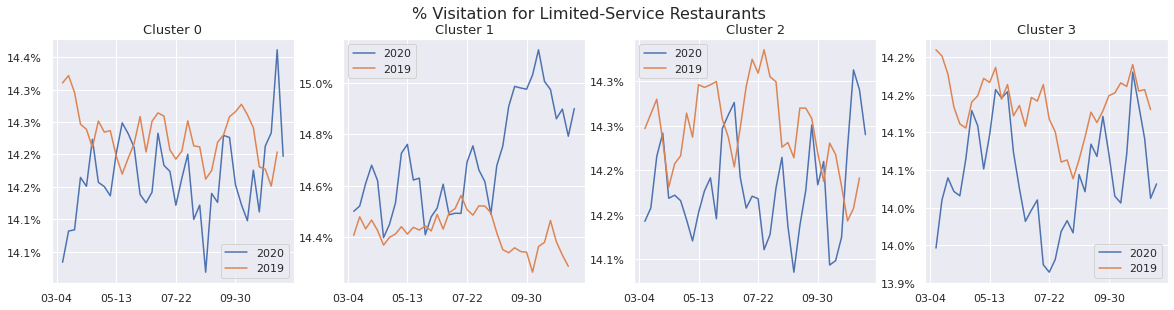

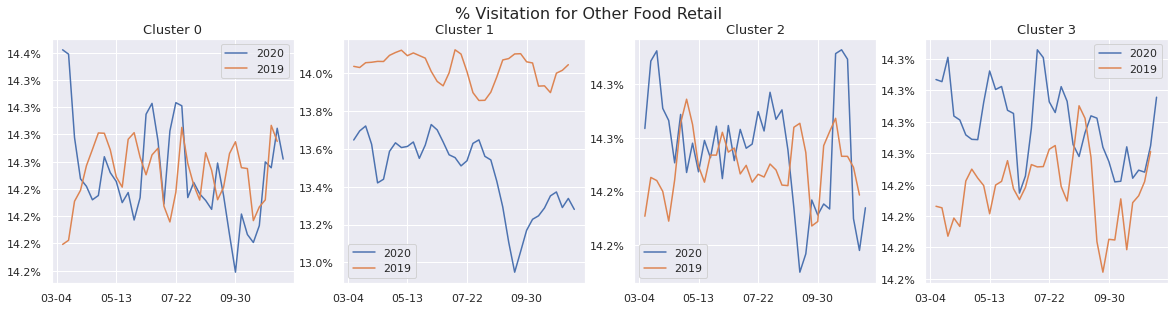

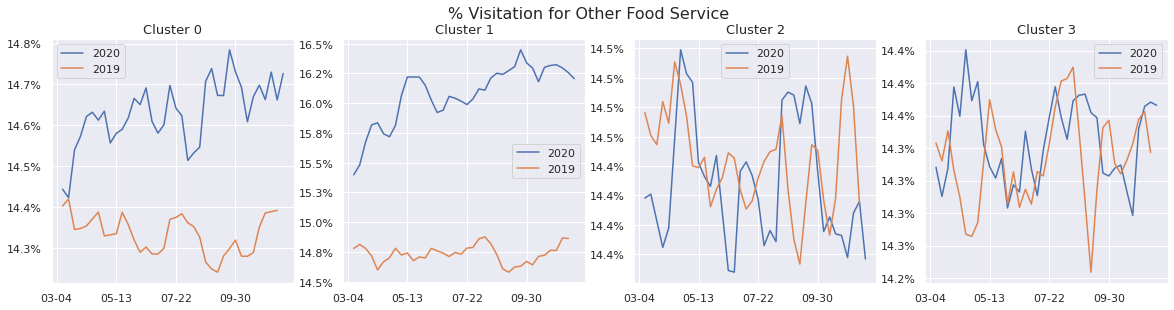

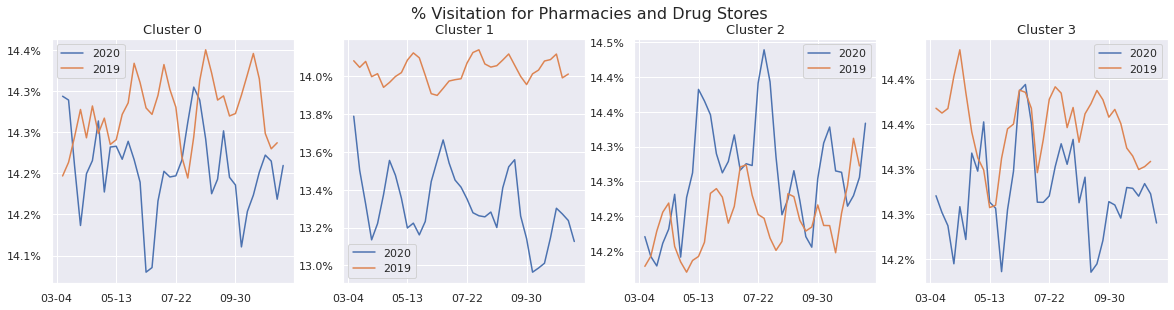

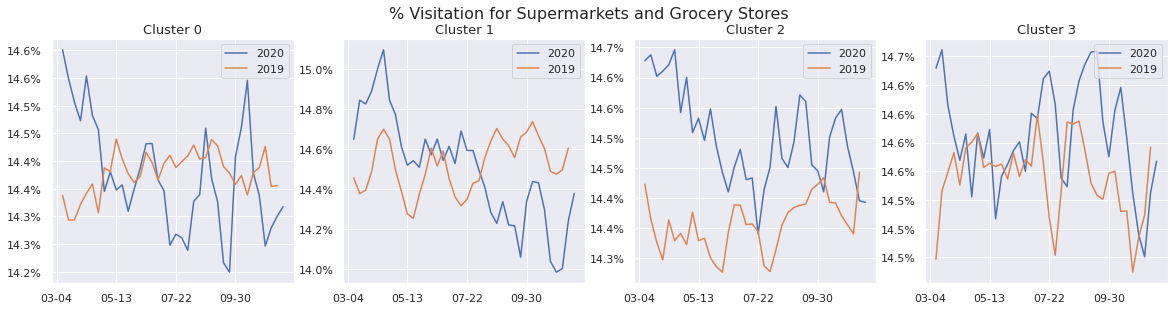

In [225]:
# COLORS = ['#57068c', '#e0b6fc', '#825', '#173', '#dc7', '#4a9', '#c67', '#993', '#a49']
for n, i in enumerate(tp20pct.columns):
    if (n-1)//4 != n//4:
        fig, axes = plt.subplots(1,4,figsize=(20,4.5))
        fig.suptitle('%% Visitation for %s ' % i[0], fontsize=16, verticalalignment='top')
        ax = axes.ravel()
    cl = n%4
    tp20pct[i].rolling(3, center=True).mean().plot(ax=ax[cl], label='2020', legend=True)
    tp19pct[i].rolling(3, center=True).mean().plot(ax=ax[cl], label='2019', legend=True)
    ax[cl].set(xlabel=None)
    ax[cl].set_title('Cluster %d' % cl, fontdict={'fontsize': 13})
    ax[cl].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, 1))

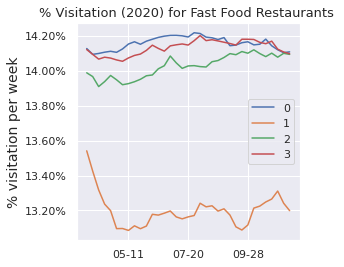

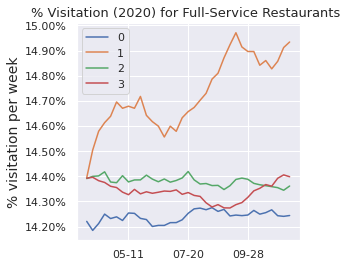

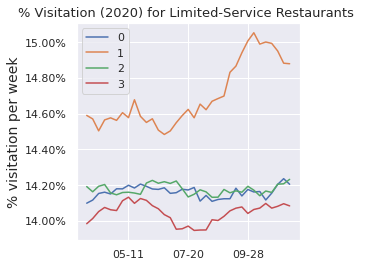

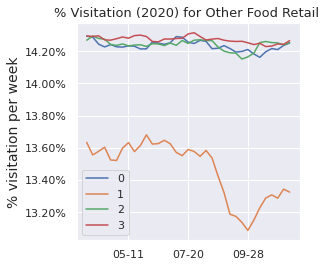

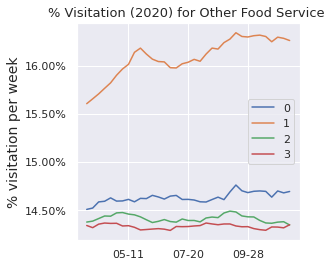

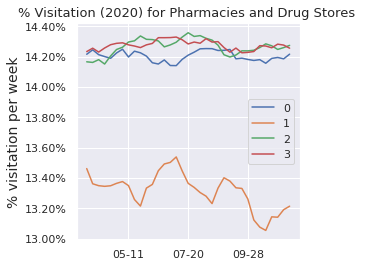

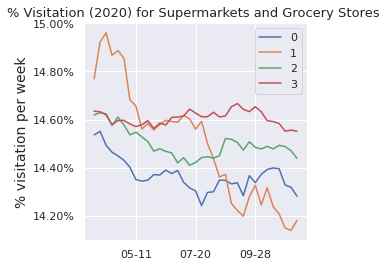

In [201]:
for n, i in enumerate(tp20pct.columns):
    if (n-1)//4 != n//4:
        fig, ax = plt.subplots(figsize=(4,4))
#         fig.suptitle('Visitation for %s ' % i[0], fontsize=14, verticalalignment='top')
    cl = n%4
    tp20pct[i].rolling(6, center=True).mean().plot(ax=ax, label=cl, legend=True) #, color=COLORS[cl]
    ax.set(xlabel=None, ylabel='% visitation per week')
    ax.set_title("%% Visitation (2020) for %s " % i[0], fontdict={'fontsize': 13})
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))